In [96]:
import os
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.metrics import accuracy_score, confusion_matrix
from vision_models import Plot
import seaborn as sns
import pandas as pd

In [97]:
results_folder = '.'
results_file = results_folder + "rule_for_NPcorrection.csv"

data_file_path = rf'data/WEO_Data_Sheet.xlsx'
dataframes_by_sheet = pd.read_excel(data_file_path, sheet_name=None)
fine_grain_results_df = dataframes_by_sheet['Fine-Grain Results']
fine_grain_classes = fine_grain_results_df['Class Name'].to_list()

In [86]:
data_dir = '.'  # Set the directory where your .npy files are located

# Initialize dictionaries to store training and test accuracy data for each model
model_train_data = {}
model_test_data = {}

test_true = np.load(os.path.join(data_dir, 'test_true.npy'))

# Loop through all files in the directory
for filename in os.listdir(data_dir):
    train_match = re.match(pattern=r'(.+?)_train_(loss|acc)_lr(.+?)_e(\d+?).npy',
                           string=filename)
    test_match = re.match(pattern=r'(.+?)_test_pred_lr(.+?)_e(\d+?).npy',
                          string=filename)

    if train_match:
        model_name = train_match.group(1)
        metric = train_match.group(2)
        lr_value = float(train_match.group(3))
        num_epochs = int(train_match.group(4)) + 1

        # Load the data from the .npy file
        data = np.load(os.path.join(data_dir, filename))

        # Store the data in the model_data dictionary
        if model_name not in model_train_data:
            model_train_data[model_name] = {}
        if metric not in model_train_data[model_name]:
            model_train_data[model_name][metric] = {}
        if lr_value not in model_train_data[model_name][metric]:
            model_train_data[model_name][metric][lr_value] = {}

        model_train_data[model_name][metric][lr_value][num_epochs] = data[-1]
    elif test_match:
        model_name = test_match.group(1)
        lr_value = float(test_match.group(2))
        num_epochs = int(test_match.group(3)) + 1

        # Load the test data from the .npy file
        test_pred = np.load(os.path.join(data_dir, filename))

        # Store the data in the model_test_data dictionary
        if model_name not in model_test_data:
            model_test_data[model_name] = {}
        if lr_value not in model_test_data[model_name]:
            model_test_data[model_name][lr_value] = {}

        model_test_data[model_name][lr_value][num_epochs] = \
            {'acc': accuracy_score(test_true, test_pred), 'cm': confusion_matrix(test_true, test_pred)}


############################################################################################################
##################################################vit_b_16##################################################
############################################################################################################


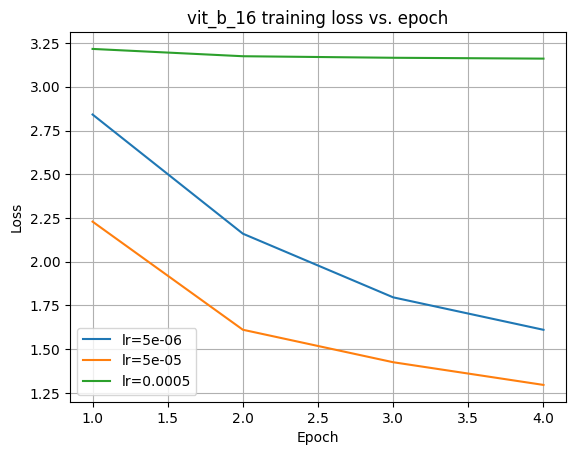

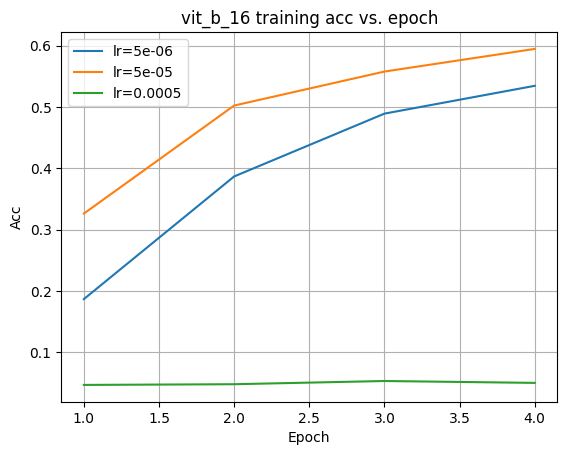


############################################################################################################
##################################################vit_b_32##################################################
############################################################################################################


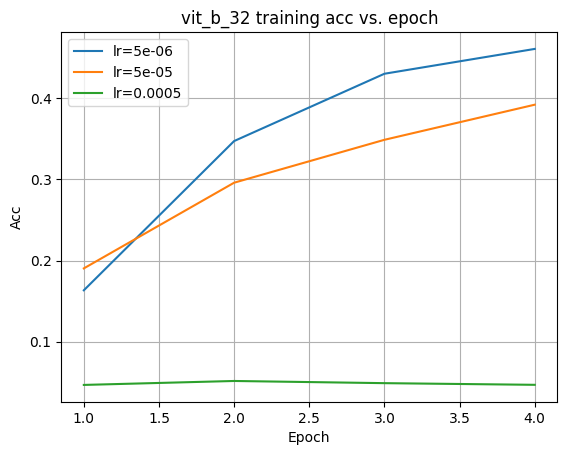

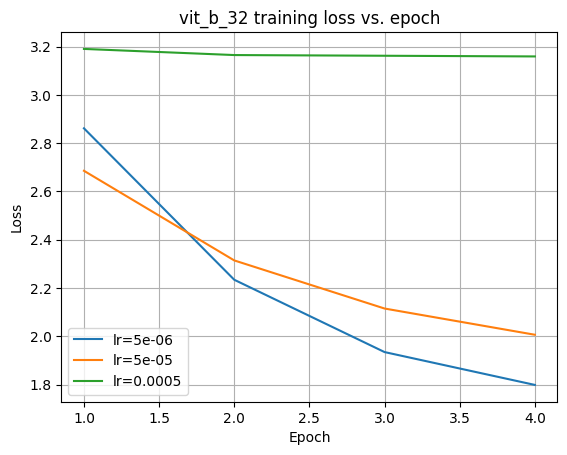


############################################################################################################
##################################################vit_l_16##################################################
############################################################################################################


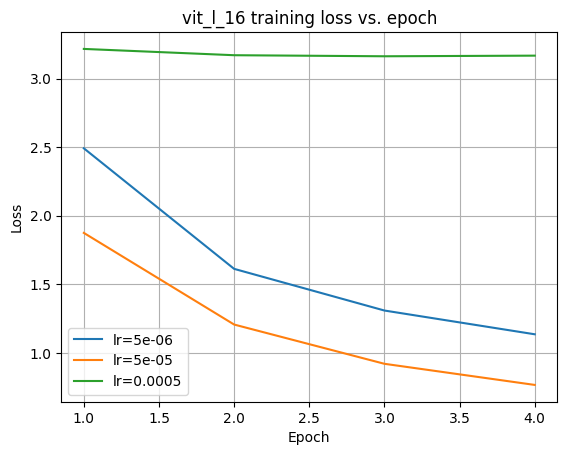

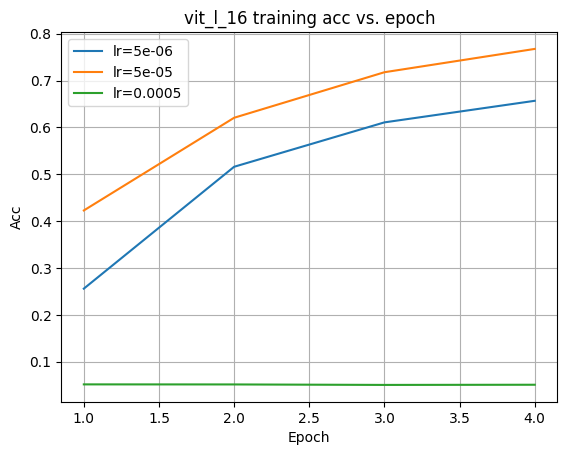


############################################################################################################
##################################################vit_l_32##################################################
############################################################################################################


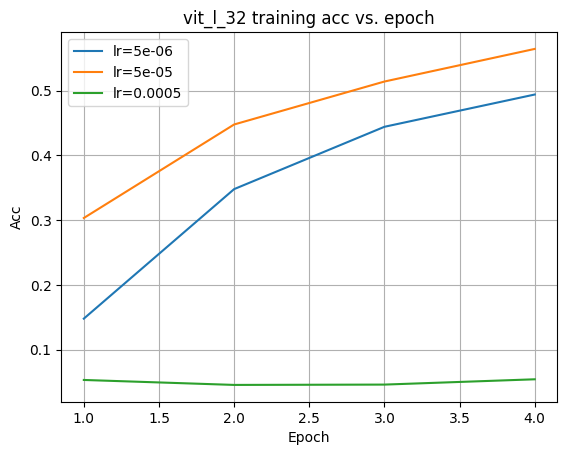

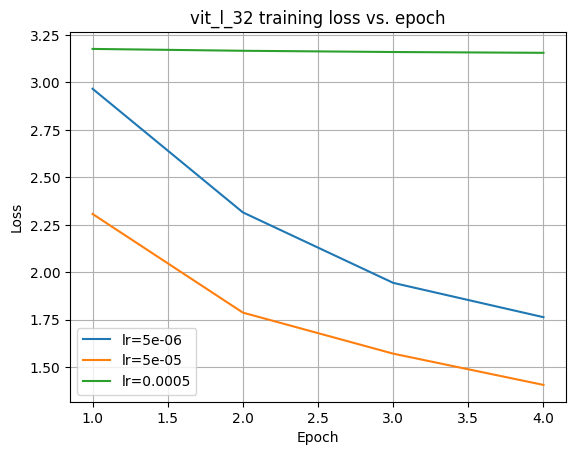

<Figure size 640x480 with 0 Axes>

In [102]:
def plot_train_metrics():
    # Create plots for training metric vs. epoch for each model
    for model_name, model_data in sorted(model_train_data.items()):
        print('\n' + '#'* (100 + len(model_name)))
        print('#'* 50 + f'{model_name}' + '#'* 50)
        print('#'* (100 + len(model_name)) + '\n')
        for metric, metric_data in model_data.items():
            with Plot():
                plt.title(f"{model_name} training {metric} vs. epoch")
                plt.xlabel('Epoch')
                plt.ylabel(metric.capitalize())
    
                for lr_value, lr_data in sorted(metric_data.items()):
                    # Sort the data based on the number of epochs
                    epochs, data = zip(*sorted(lr_data.items()))
                    plt.plot(epochs, data, label=f'lr={lr_value}')
    
                plt.legend()
                plt.grid()

plot_train_metrics()


############################################################################################################
##################################################vit_b_16##################################################
############################################################################################################


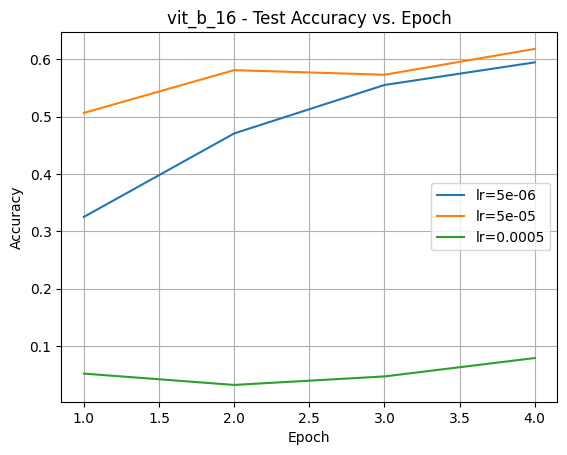

<Figure size 640x480 with 0 Axes>

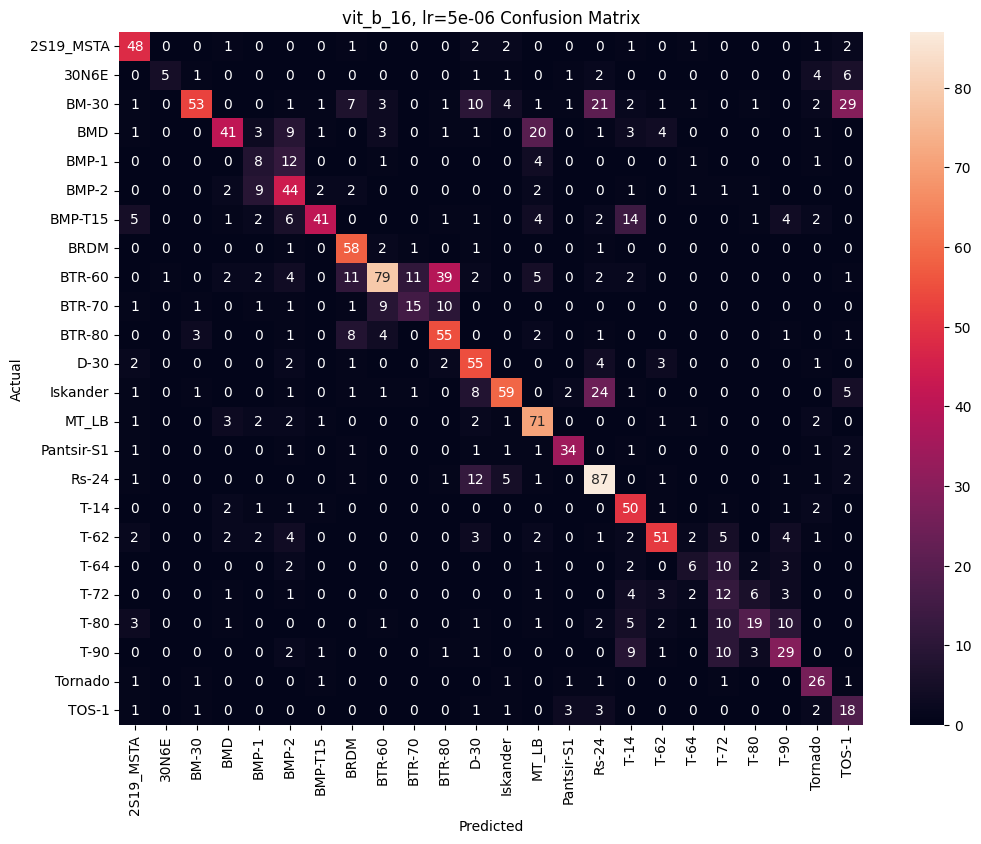

<Figure size 640x480 with 0 Axes>

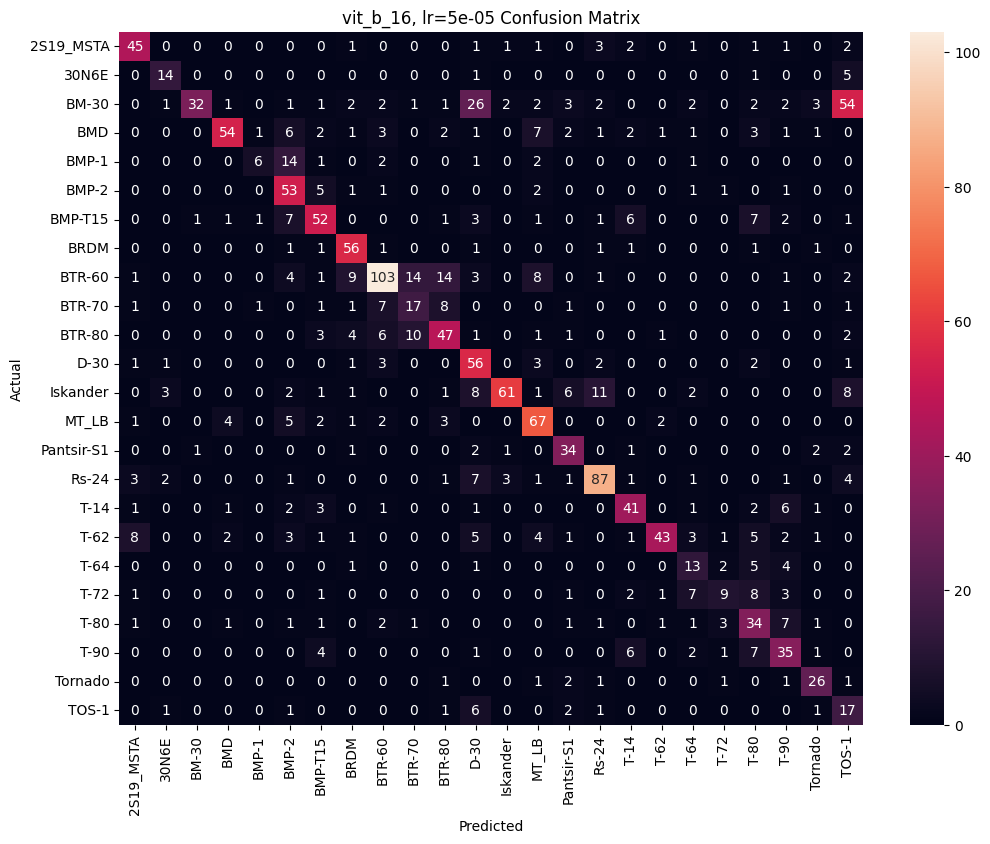

<Figure size 640x480 with 0 Axes>

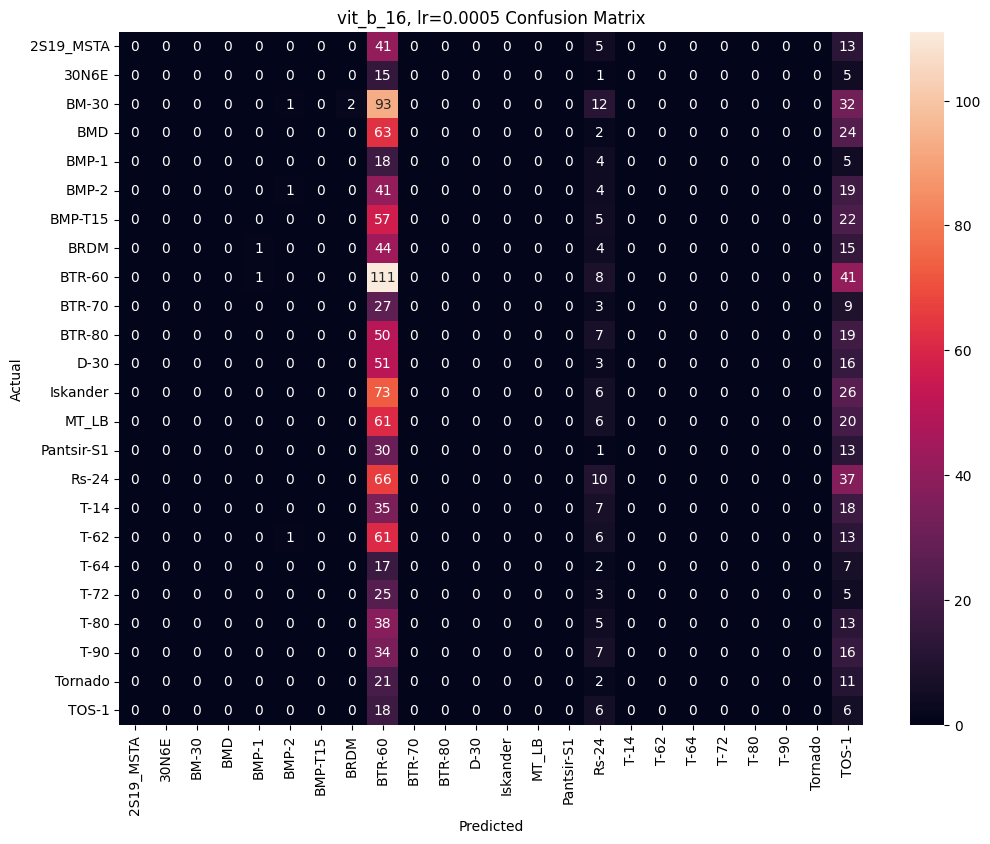


############################################################################################################
##################################################vit_b_32##################################################
############################################################################################################


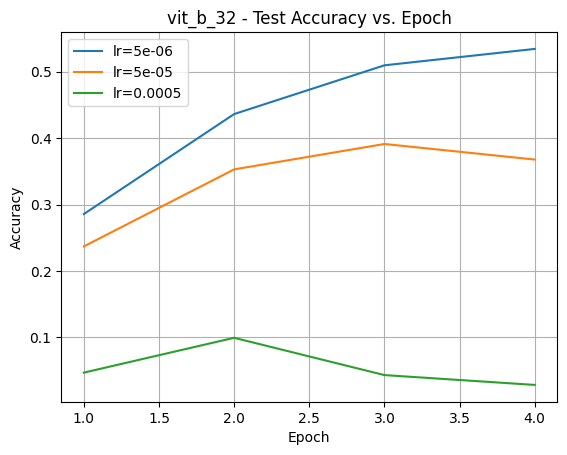

<Figure size 640x480 with 0 Axes>

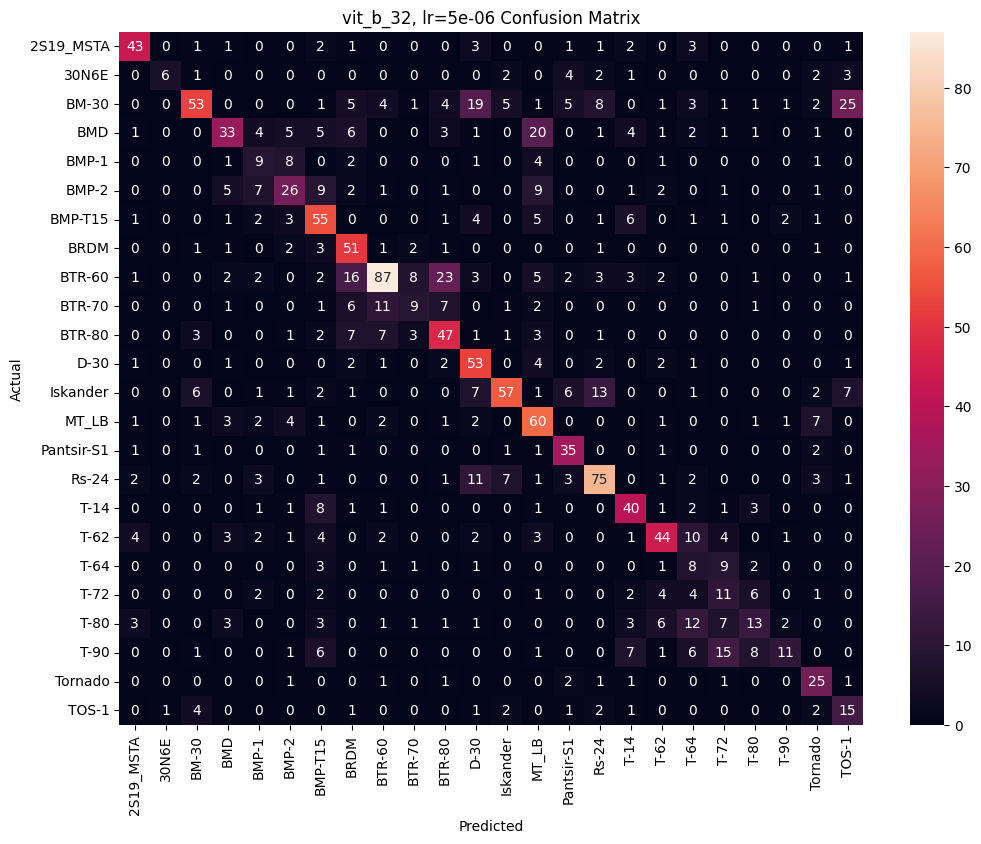

<Figure size 640x480 with 0 Axes>

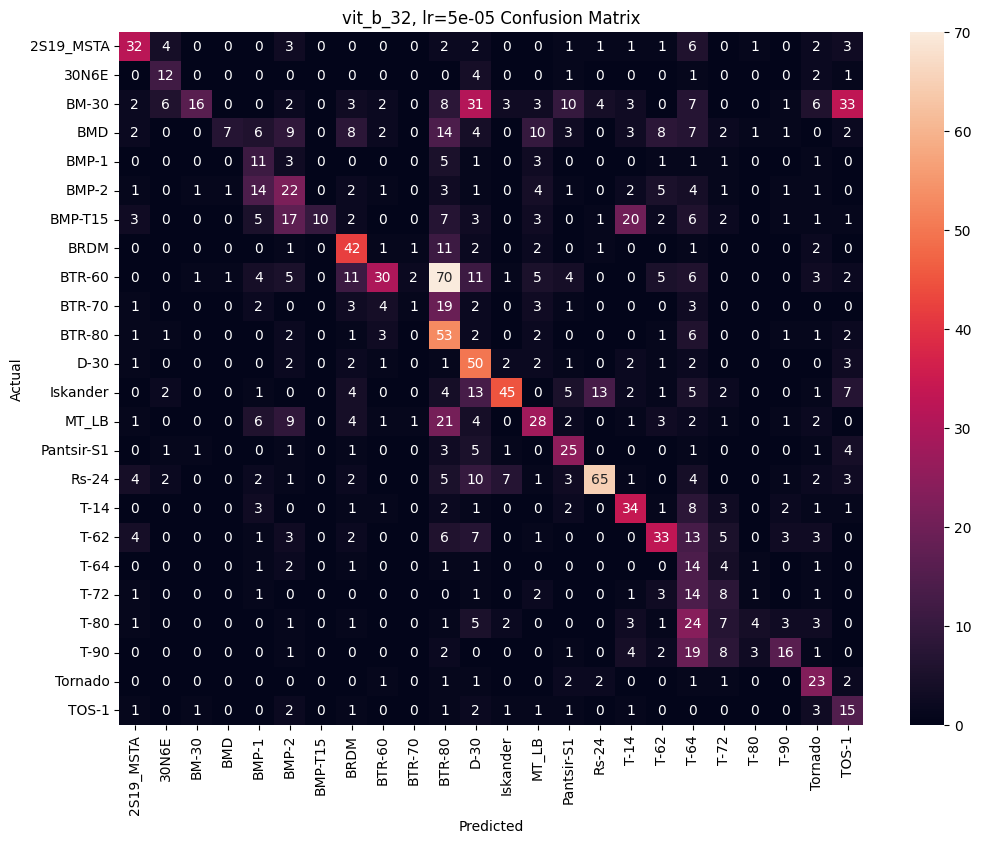

<Figure size 640x480 with 0 Axes>

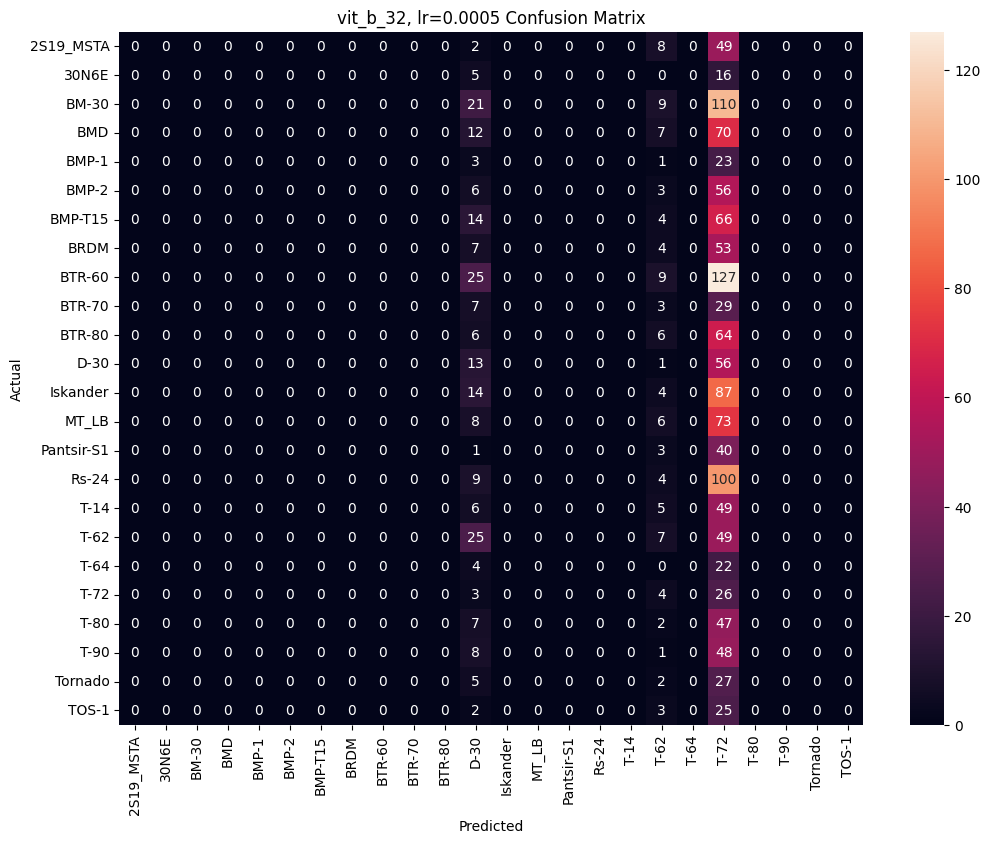


############################################################################################################
##################################################vit_l_16##################################################
############################################################################################################


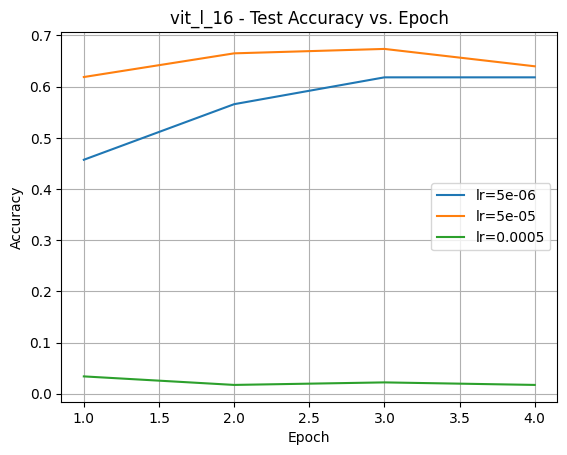

<Figure size 640x480 with 0 Axes>

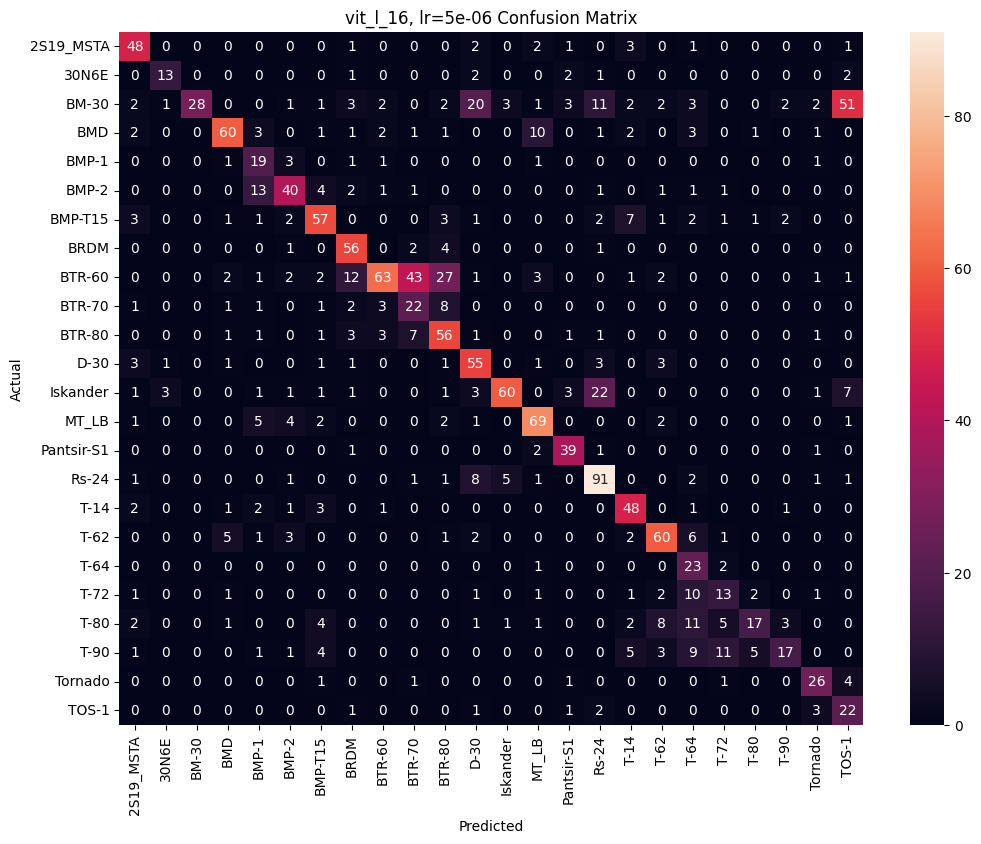

<Figure size 640x480 with 0 Axes>

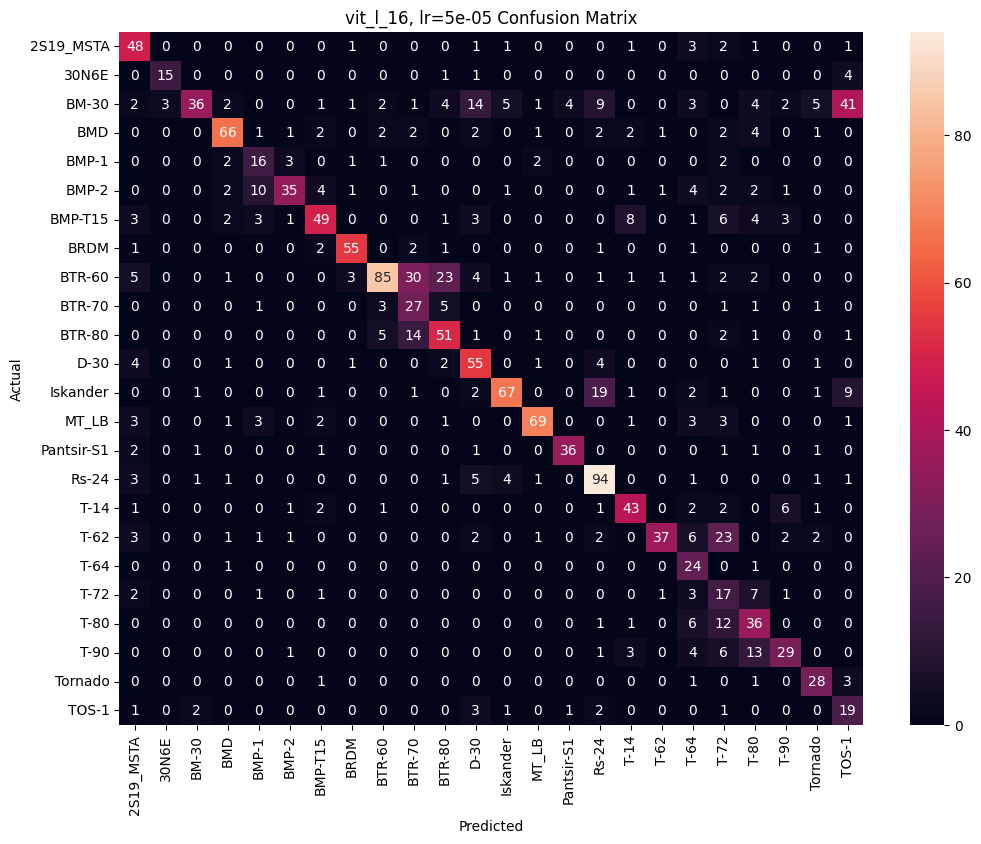

<Figure size 640x480 with 0 Axes>

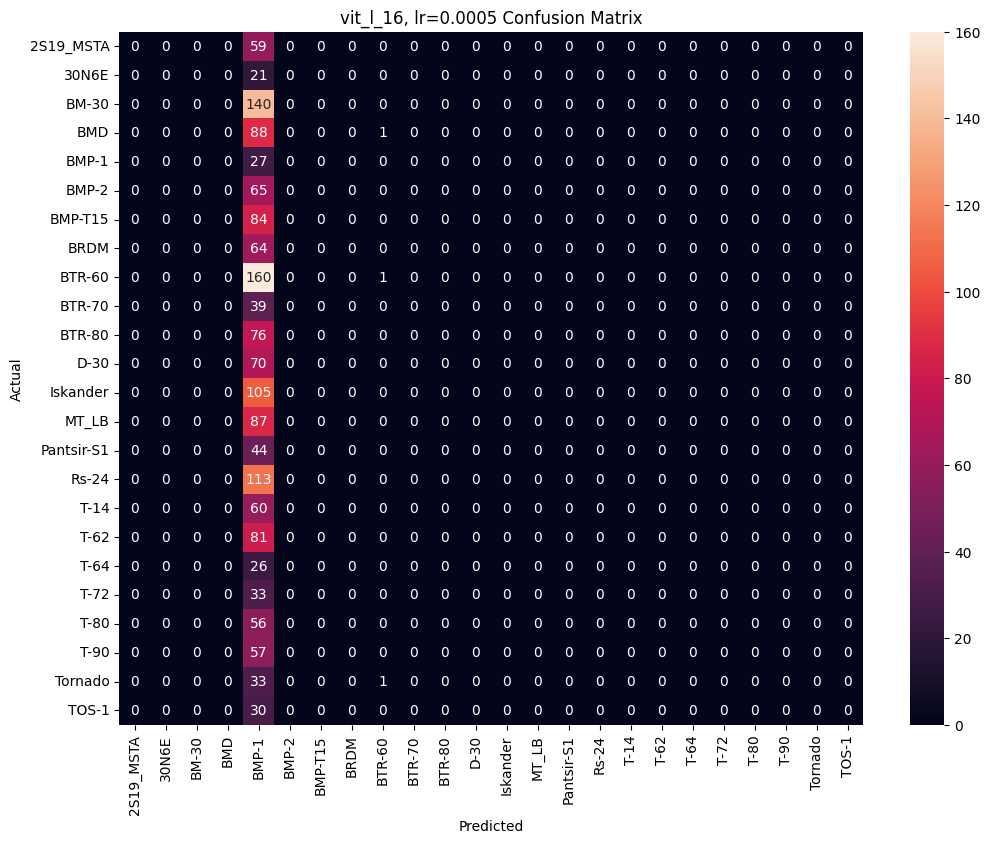


############################################################################################################
##################################################vit_l_32##################################################
############################################################################################################


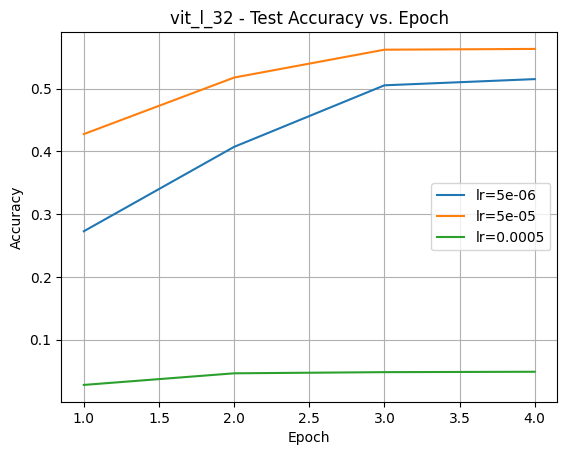

<Figure size 640x480 with 0 Axes>

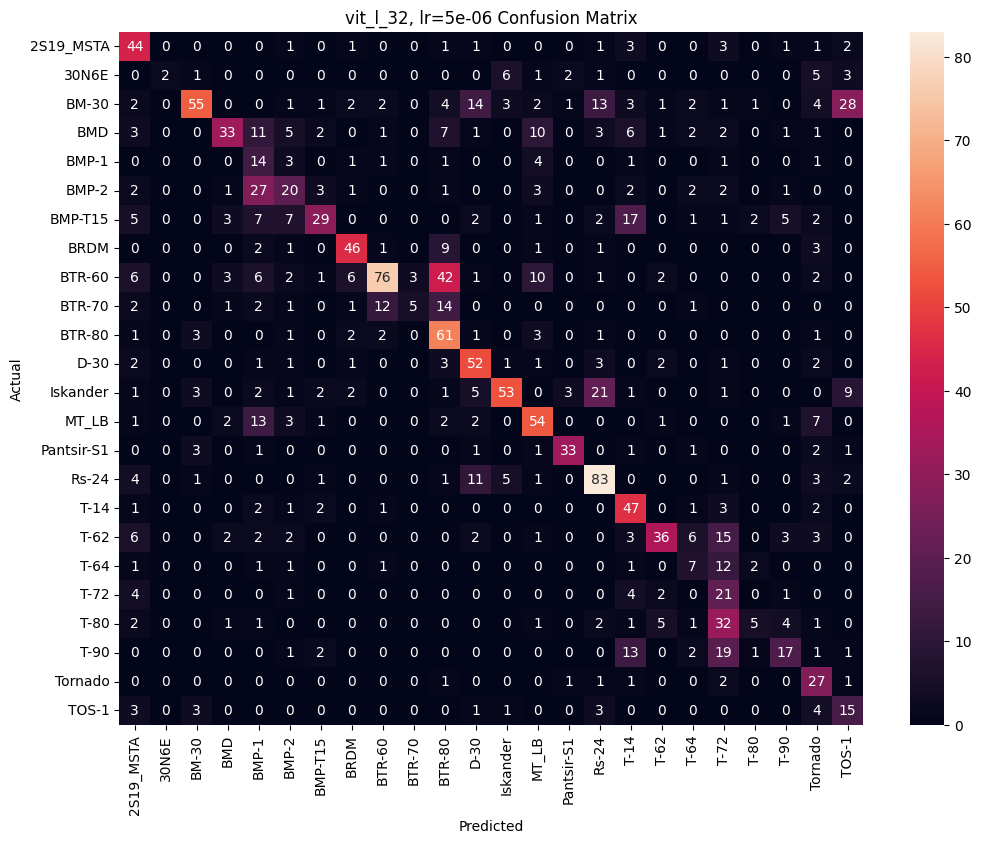

<Figure size 640x480 with 0 Axes>

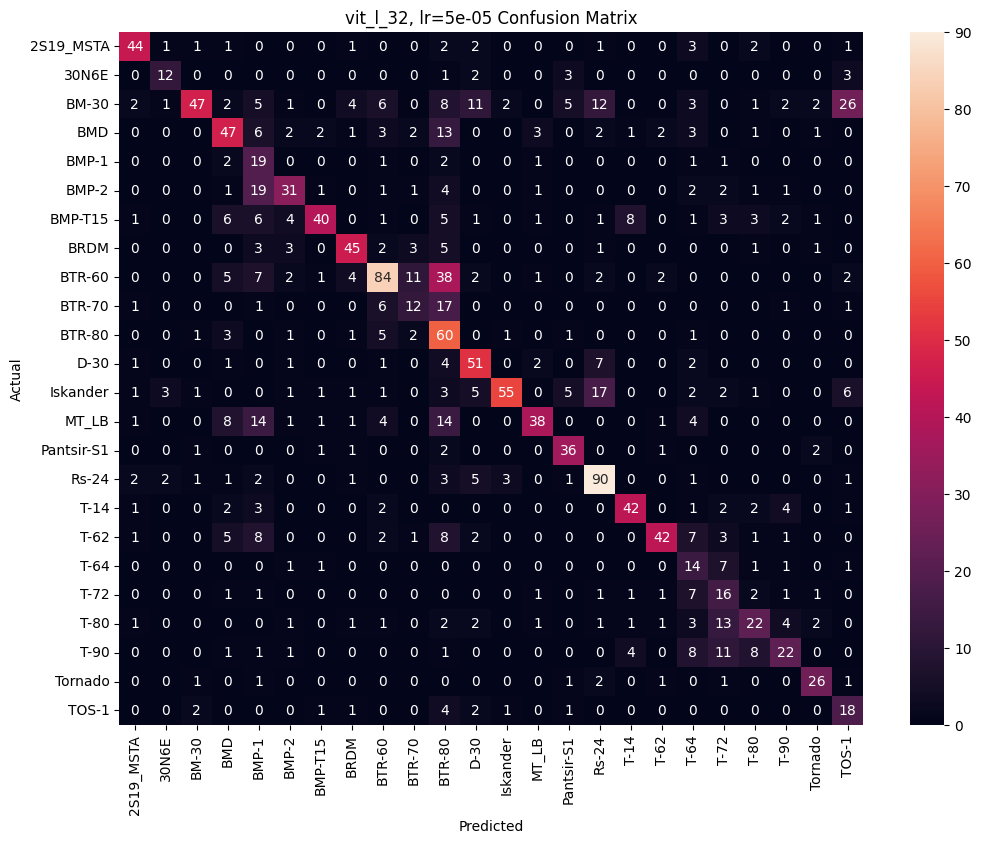

<Figure size 640x480 with 0 Axes>

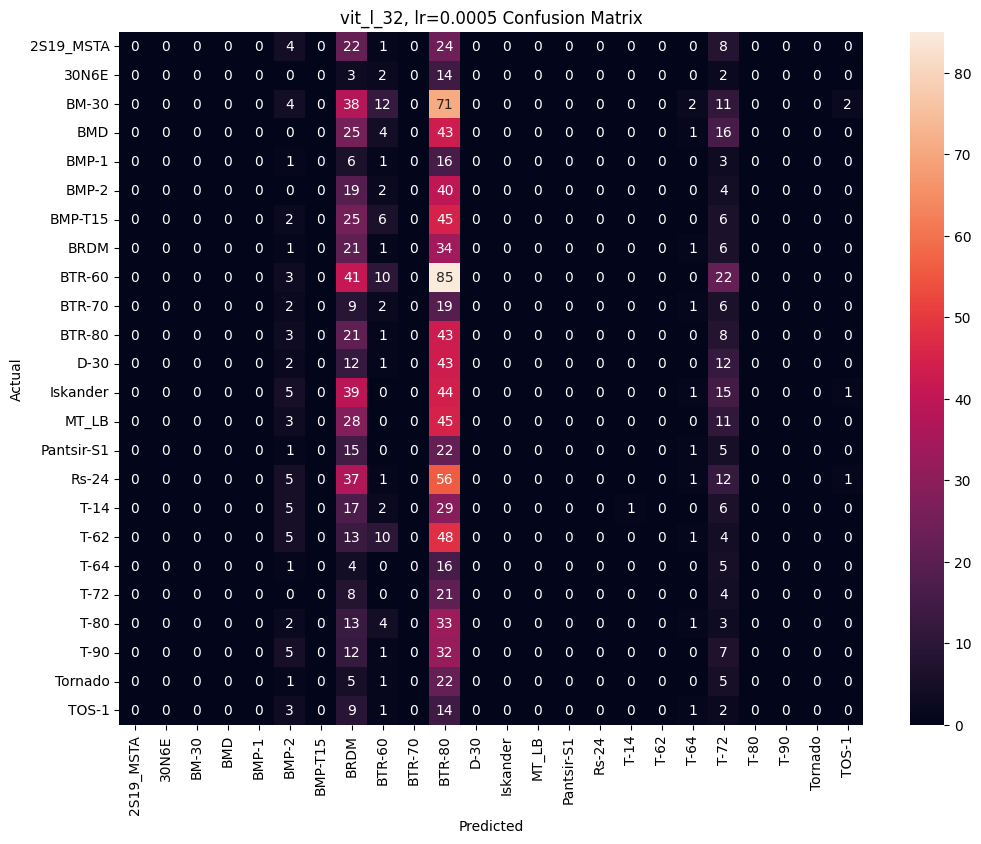

<Figure size 640x480 with 0 Axes>

In [101]:
def plot_test_metrics():
    # Now, create plots for test accuracy vs. epoch for each model
    for model_name, model_data in sorted(model_test_data.items()):
        print('\n' + '#'* (100 + len(model_name)))
        print('#'* 50 + f'{model_name}' + '#'* 50)
        print('#'* (100 + len(model_name)) + '\n')
        metric = 'Accuracy'
        
        with Plot():
            plt.title(f"{model_name} - Test {metric} vs. Epoch")
            plt.xlabel('Epoch')
            plt.ylabel(metric)
    
            for lr_value, lr_data in sorted(model_data.items()):
                # Sort the data based on the number of epochs
                epochs, epoch_data = zip(*sorted(lr_data.items()))
                plt.plot(epochs, [curr_data['acc'] for curr_data in epoch_data], label=f'lr={lr_value}')
    
            plt.legend()
            plt.grid()
        
        for lr_value, lr_data in sorted(model_data.items()):
            epochs, epoch_data = zip(*sorted(lr_data.items()))
            
            with Plot():
                plt.figure(figsize=(12, 9))
                sns.heatmap(epoch_data[-1]['cm'], 
                            annot=True, 
                            fmt="d",  
                            xticklabels=fine_grain_classes, 
                            yticklabels=fine_grain_classes
                            )
                
                plt.xlabel('Predicted')
                plt.ylabel('Actual')
                plt.title(f'{model_name}, lr={lr_value} Confusion Matrix')
            
plot_test_metrics()